# Treinando um classificador

Bom, já vimos como definir uma rede neural, computar perda e atualizar os pesos da rede.

**E agora?**

Geralmente, quando temos que lidar com dados de imagem, texto, áudio ou vídeo, podemos usar pacotes padrões de python que carregam os dados em um _array_ de NumPy. Então convertemos este _array_ em um `torch.*Tensor`.

* Para imagens, pacotes como Pillow, OpenCV são úteis
* Para áudio, pacotes como Scipy e Librosa
* Para texto, tanto leituras baseados em Python \"cru\" ou Cython, ou NLTK e SpaCy são úteis.

Especificamente para visão, há um pacote chamado `torchvision`, que tem carregadores de dados para _datasets_ comuns como _Imagenet_, CIFAR10, MNIST, entre outros, e transformadores de dados para imagens, viz., `torchvision.datasets` e `torch.utils.data.DataLoader`.

Esse pacote é bastante conveniente e evita escrever códigos clichês.

Para este tutorial, usaremos o _dataset_ CIFAR10. Este contém as classes: _'airplane'_, _'automobile'_, _'bird'_, _'cat'_, _'deer'_, _'dog'_, _'frog'_, _'horse'_, _'ship'_, _'truck'_. As imagens no CIFAR10 são de tamanho 3x32x32, i.e. 3 canais de cores de imagens de tamanho 32x32 pixels.

![cifar10](./img/cifar10.png)

## Treinando um classificador de imagem

Seguiremos os seguintes passos:

1. Carregar e normalizar os _datasets_ de treinamento e de teste do CIFAR10, usando `torchvision`
2. Definir uma Rede Neural Convolutiva
3. Definir uma função de perda
4. Treinar a rede sobre os dados de treinamento
5. Testar a rede nos dados de teste

### 1. Carregar e normalizar CIFAR10

Usando `torchvision` é extremamente fácil de carregar o CIFAR10.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

A saída dos _datasets_ do `torchvision` são imagens _PILImage_ de variação [0, 1]. Devemos transformá-los em Tensores de variação normalizada [-1, 1]. Obs.:
> Se rodar no Windows e retornar um <span style="color:red">**BrokenPipeError**</span>, tente configurar o `num_worker` do `torch.utils.data.DataLoader()` para 0.

In [2]:
transform = transforms.Compose(
            [transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root = "./data",
                                        train=True,
                                        download=True,
                                        transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                        batch_size=4,
                                        shuffle=True,
                                        num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data',
                                      train=False,
                                      download=True,
                                      transform=transform)
testloader = torch.utils.data.DataLoader(testset,
                                        batch_size=4,
                                        shuffle=False,
                                        num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Vamos mostrar algumas imagens de treinamento, só pro diversão. :)

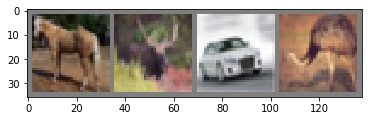

horse  deer   car  bird


In [3]:
import matplotlib.pyplot as plt
import numpy as np


# funções para mostrar uma imagem
def imshow(img):
    img = img / 2 + 0.5     # desnormalizar
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# pega algumas imagens aleatórias de treinamento
dataiter = iter(trainloader)
images, labels = dataiter.next()

# mostra as imagens
imshow(torchvision.utils.make_grid(images))
# imprime os labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### 2. Definir uma Rede Neural Convolutiva

Copie a rede neural da sessão [Redes Neurais](Redes_Neurais.ipynb) e modifique-a para receber imagens de 3 canais (ao invés de imagens de 1 canal).

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### 3. Definir uma função de perda e um otimizador

Vamos usar a _Classification Cross-Entropy loss_ e SGD com _momentum_.

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Treino da rede

Aqui é onde as coisas começam a ficar interessantes. Temos apenas que fazer um looping sobre nosso iterador de dados, e alimentar a entrada da rede e otimizar.

In [6]:
for epoch in range(2):  # looping sobre o dataset várias vezes

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # pega as entradas; dados é uma lista de [inputs, labels]
        inputs, labels = data

        # zera os gradientes dos parâmetros
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # imprime as estatísticas
        running_loss += loss.item()
        if i % 2000 == 1999:    # imprime a cada 2000 mini-lotes
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Treino Finalizado')

[1,  2000] loss: 2.196
[1,  4000] loss: 1.847
[1,  6000] loss: 1.677
[1,  8000] loss: 1.589
[1, 10000] loss: 1.516
[1, 12000] loss: 1.491
[2,  2000] loss: 1.409
[2,  4000] loss: 1.407
[2,  6000] loss: 1.350
[2,  8000] loss: 1.331
[2, 10000] loss: 1.311
[2, 12000] loss: 1.320
Finished Training


Vamos rapidamente salvar nosso modelo treinado.

In [7]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

Para mais informações sobre salvar modelos PyTorch, veja [aqui](https://pytorch.org/docs/stable/notes/serialization.html).

### 5. Teste da rede

Treinamos a rede em 2 passes pelo _dataset_ de treinamento. Agora precisamos chegar se a rede aprendeu alguma coisa.

Checaremos isso através da comparação da classificação da rede neural com o _ground-truth_. Se a predição for correta, adicionamos a amostra à lista de predições corretas.

Okay, primeiro passo. Vamos exibir uma imagem do conjunto de teste para nos familiarizar.

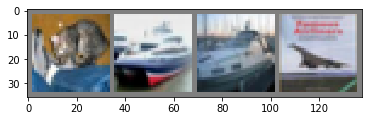

GroundTruth:    cat  ship  ship plane


In [10]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# imprime imagens
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

A seguir, vamos carregar nosso modelo salvo (nota: salvar e recarregar o model não foi necessário aqui, apenas o fizemos para ilustrar como se faz).

In [11]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Okay, agora vejamos o que a rede neural pensa que são as imagens exemplos acima.

In [12]:
outputs = net(images)

As saídas são energias para as 10 classes. Quanto mais alta a energia para a classe, mais a rede pensa que a imagem é de uma classe particular. Então, vamos pegar o índice da anergia mais alta.

In [15]:
_, predicted = torch.max(outputs, 1)

print('Predito: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predito:    cat  ship   car  ship


Os resultados parecem razoáveis.

Vamos ver como a rede performa no _dataset_ inteiro.

In [16]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Acurácia da rede nos 10000 imagens de teste: %d %%' % (
    100 * correct / total))

Acurácia da rede nos 10000 imagens de teste: 53 %


Isso parece bem melhor do que o acaso, que teria 10% de acurácia (se pegasse aleatoriamente uma classe de 10 classes). Então parece que a rede aprendeu algo.

Bom, quais são as classes nas quais a rede obteve e não obteve boa performance?

In [17]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Acurácia of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Acurácia of plane : 45 %
Acurácia of   car : 77 %
Acurácia of  bird : 49 %
Acurácia of   cat : 21 %
Acurácia of  deer : 55 %
Acurácia of   dog : 54 %
Acurácia of  frog : 55 %
Acurácia of horse : 57 %
Acurácia of  ship : 76 %
Acurácia of truck : 44 %


Okay, e agora?

Como rodamos esta rede neural na GPU?

## Treinando na GPU

Da mesma forma que transferimos um Tensor a um GPU, transferimos a rede neural ao GPU.

Vamos primeiro definir nosso dispositivo como o primeiro CUDA visível, se tivermos CUDA disponível.

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assumindo que estamos em uma máquina CUDA, um dispositivo CUDA deve ser impresso.
print(device)

cuda:0


O resto desta sessão assume que `device` é um dispositivo CUDA.

Então, estes métodos irão recursivamente em todos os módulos e converter seus parâmetros e _buffers_ em tensors CUDA.

In [19]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Lembre-se que teremos que enviar as _inputs_ e _targets_ (entradas e alvos) em todos os passos ao GPU também.

In [20]:
inputs, labels = data[0].to(device), data[1].to(device)

Por que não podemos notar aumento MASSIVO de velocidade comparado ao CPU?
Porque esta rede é muito pequena!

> Referência: [TRAINING A CLASSIFIER](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py)

# Exercício

Tente aumentar a largura da sua rede (argumento 2 da primeira `nn.Conv2d`, e argumento 1 da segunda `nn.Conv2d` - eles precisam ser de mesmo valor), veja que tipo de aumento de velocidade consegue.

<!-- Veja solução [aqui](./Exercicio.ipynb). -->